<a href="https://colab.research.google.com/github/DCDPUAEM/DCDP/blob/main/03-Deep-Learning/notebooks/02-MLP-SOL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Conectar la notebook en modo GPU

Entorno de ejecución → Cambiar tipo de entorno de ejecución

Algunas consideraciones:

* No dejar la notebook conectada sin actividad ya que Colab penaliza esto al asignar un entorno con GPU.
* No pedir el entorno con GPU si no se va a usar.

# Redes Neuronales MLP para clasificación

<img align="center" width="50%" src="../img/mlp.png"/>

En esta notebook usaremos una red neuronal de tipo **MultiLayer Perceptron (MLP)** para el problema de clasificación en el dataset MNIST. 

Al final, practicaremos el uso de estas redes para buscar un mejor modelo para esta tarea.

Benchmarks para el dataset MNIST

1. **No Routing Needed Between Capsules**, 2020. *Accuracy: 99.87%* 

    Modelo de redes CNN con Homogeneous Vector Capsules (HVCs) que modifican el flujo de datos entre capas. [Artículo](https://arxiv.org/abs/2001.09136), [código](https://github.com/AdamByerly/BMCNNwHFCs).

2. **An Ensemble of Simple Convolutional Neural Network Models for MNIST Digit Recognition**, 2020. *Accuracy: 99.87%*

    Modelo de ensamble de redes CNN [Artículo](https://arxiv.org/abs/2008.10400), [código](https://github.com/ansh941/MnistSimpleCNN).

## 1. El conjunto de datos

Observar que, ahora sí, usamos todo el conjunto de datos completo.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

# Load MNIST handwritten digit data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

y_test_original = y_test.copy()  # Hacemos una copia del 'y_test', la usaremos al final

X_train shape: (60000, 28, 28)
y_train shape: (60000,)
X_test shape: (10000, 28, 28)
y_test shape: (10000,)


Visualizamos 6 ejemplos, junto con sus etiquetas

In [ ]:
# ------ Obtenemos algunos índices aleatorios:
some_idxs = np.random.choice(list(range(y_train.shape[0])),size=6,replace=False)

fig, axes = plt.subplots(ncols=6, sharex=False,
			 sharey=True, figsize=(10, 4))
for i,idx in enumerate(some_idxs):
	axes[i].set_title(y_train[idx],fontsize=15)
	axes[i].imshow(X_train[idx], cmap='gray')
	axes[i].get_xaxis().set_visible(False)
	axes[i].get_yaxis().set_visible(False)
plt.show()

## Definiendo la red

Al usar redes neuronales, usalmente el vector de etiquetas debe estar codificado como vectores **one-hot**. Es decir:

$$1 → (1,0,...,0) $$
$$2 → (0,1,...,0) $$
$$ ... $$

Entonces, las etiquetas $y$ son matrices de tamaño $N\times m$ donde 

* $N$: número de instancias
* $m$: número de clases

Hacemos la codificación usando la función [`to_categorical`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) de [keras](https://www.tensorflow.org/guide/keras).

In [ ]:
from tensorflow.keras.utils import to_categorical

print("---------- Antes de la codificación ----------")
print(f"Primeras 5 etiquetas: {y_train[:5]}")
print(f"Shape: {y_train.shape}")

y_train = to_categorical(y_train,num_classes=10)

print("---------- Después de la codificación ----------")
print(f"Primeras 5 etiquetas:\n{y_train[:5]}")
print(f"Shape: {y_train.shape}")

y_test = to_categorical(y_test,num_classes=10)

En TensorFlow las redes se definen a partir de los tipos de capas y elementos, de manera secuencial y por separado:

* **Dense**: implementa la operación: output = activation(dot(input, kernel) + bias) donde activation es la función de activación por elementos pasada como argumento de activación, kernel es una matriz de pesos creada por la capa, y bias es un vector de sesgo creado por la capa (sólo aplicable si use_bias es True). 
* **Flatten**: Aplana los datos para tener un arreglo unidimensional.
* **Sequential**: Agrupa una secuencia de capas para formar un modelo.

In [ ]:
from keras.layers import Dense, Flatten
from keras.models import Sequential

Definimos la arquitectura de la red neuronal. Observa la elección de:
* Activaciones
* Función de perdida
* Optimizador
* Métrica de desempeño 

In [ ]:
model = Sequential()
model.add(Flatten(input_shape=(28,28)))
model.add(Dense(8, activation='tanh'))
model.add(Dense(10, activation='softmax'))  # Cuando se trata de tareas de clasificación multiclase, ponemos una activación softmax en la capa de salida

model.summary()

model.compile(loss='categorical_crossentropy', 
	      optimizer='adam',
	      metrics=['acc']
		  )

## ➖ Visualizando la arquitectura de la red 

Esto es opcional

A continuación se presentan dos maneras de visualizar la arquitectura de la red.

### 1. Usando visualkeras

In [ ]:
!pip install -q visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 13.0 MB/s eta 0:00:00


In [ ]:
from visualkeras import layered_view

layered_view(model,legend=True, draw_volume=True,draw_funnel=True)

### Usando `plot_model` de keras

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

## Entrenando la red

Entrenamos la red con el método `fit`, usamos 8 épocas

Observa que, para realizar el entrenamiento, usamos el conjunto de validación también. Este sirve para proporcionar un indicador no sesgado del desempeño del modelo.

<img align="left" width="50%" src="../img/training-validation-test.png"/> 

In [ ]:
n_epocas = 8

history = model.fit(X_train, y_train, epochs=n_epocas, validation_data=(X_test,y_test))

Graficamos la función de perdida en cada época, tanto en el conjunto de entrenamiento, como en el de validación.

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']

epochs = range(1,n_epocas+1)

plt.figure(figsize=(7,5))
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss',fontsize=15)
plt.xlabel('Epochs',fontsize=14)
plt.ylabel('Loss',fontsize=14)
plt.legend()
plt.show()

Ahora, graficamos el accuracy a lo largo del entrenamiento, tanto en el conjunto de entrenamiento como en el validación.

In [ ]:
loss_train = history.history['acc']
loss_val = history.history['val_acc']

epochs = range(1,n_epocas+1)

plt.figure(figsize=(7,5))
plt.plot(epochs, loss_train, 'g', label='Training Accuracy')
plt.plot(epochs, loss_val, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.xticks(epochs)
plt.legend()
plt.show()

De la siguiente forma podemos acceder a la matriz de pesos y sesgos en cada capa. Las guardamos como arreglos de numpy. Son los pesos usados en la notebook anterior.

In [ ]:
first_layer_weights = model.layers[1].get_weights()[0]
first_layer_biases  = model.layers[1].get_weights()[1]

np.save("mnist_weights1.npy",first_layer_weights)
np.save("mnist_biases1.npy",first_layer_biases)

In [ ]:
second_layer_weights = model.layers[2].get_weights()[0]
second_layer_biases  = model.layers[2].get_weights()[1]

np.save("mnist_weights2.npy",second_layer_weights)
np.save("mnist_biases2.npy",second_layer_biases)

## Predicciones y rendimiento

¿Cómo se ven las predicciones?

In [ ]:
x = X_test[0].copy()

# ----- Graficamos este primer ejemplo de prueba:
plt.figure()
plt.suptitle(y_test_original[0],fontsize=15)
plt.imshow(x, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

# ----- Cambiamos a la forma adecuada para entrar a la red neuronal:
x_input = x.reshape(-1,x.shape[0],x.shape[1])

# ----- Lo pasamos por la red neuronal ya entrenada:
prediction = model.predict(x_input)
print(f"\nSalida de la red neuronal para este primer elemento:\n {np.round(prediction,3)}\n")

print(f"Son probabilidades, la suma de las entradas es {np.sum(prediction)}")

# ----- Tomamos el argmax:
prediction = np.argmax(prediction, axis=1)
print(f"\nTomamos el índice de la entrada con mayor probabilidad: {prediction}")

Obtenemos todas las predicciones sobre el conjunto de prueba:

In [ ]:
predictions_matrix = model.predict(X_test)
predictions = np.argmax(predictions_matrix, axis=1)

313/313 [==============================] - 1s 3ms/step


Visualizamos algunas predicciones

In [ ]:
fig, axes = plt.subplots(ncols=10, sharex=False,
			 sharey=True, figsize=(18, 4))
for i in range(10):
	axes[i].set_title(predictions[i])
	axes[i].imshow(X_test[i], cmap='gray')
	axes[i].get_xaxis().set_visible(False)
	axes[i].get_yaxis().set_visible(False)
plt.show()

Obtenemos las métricas de desempeño de la tarea de clasificación. Observar que ambas son **vectores** de etiquetas

In [ ]:
print(predictions.shape)
print(y_test_original.shape)

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

print(f"Test Accuracy: {accuracy_score(y_pred=predictions,y_true=y_test_original)}")
print(f"Test Recall: {recall_score(y_pred=predictions,y_true=y_test_original,average='macro')}")
print(f"Test Precision: {precision_score(y_pred=predictions,y_true=y_test_original,average='macro')}")

Calculamos el roc-auc score

In [ ]:
from sklearn.metrics import roc_auc_score

print(f"Shape de y_test: {y_test.shape}")
print(f"Shape de las predicciones para el conjunto de prueba: {predictions_matrix.shape}")

roc_auc_score(y_test,predictions_matrix)

Mostramos la matriz de confusión

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def show_confusion_matrix(confusion_matrix):
  plt.figure(dpi=120)
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  new_xticks =  [str(int(x.get_text())+1) for x in hmap.xaxis.get_ticklabels()]
  new_yticks =  [str(int(x.get_text())+1) for x in hmap.yaxis.get_ticklabels()]
  hmap.xaxis.set_ticklabels(new_xticks, rotation=0, ha='right')
  hmap.yaxis.set_ticklabels(new_yticks, rotation=0, ha='right')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

cm = confusion_matrix(y_test_original,predictions)
show_confusion_matrix(cm)

⭕ ¿Qué dígitos son los que más confunde la red?

---

## ⭕ Práctica

Modifica el módelo de red neuronal MLP cambiando los siguientes hiperparámetros:

* Número de capas ocultas (prueba al menos con una y dos capas ocultas).
* Número de neuronas en cada capa oculta.
* Función de activación de la capa oculta.
* Optimizador ([opciones](https://keras.io/api/optimizers/)).

**Objetivo:** Subir las métricas de desempeño: accuracy y roc-auc score.

Como referencia, el mejor resultado hasta ahora, sin usar redes convolucionales, es un accuracy de 99.65% (https://arxiv.org/abs/1003.0358)

Lista de resultados: http://yann.lecun.com/exdb/mnist/, https://paperswithcode.com/sota/image-classification-on-mnist



---

Esta es una estrategia que produce alrededor del 91% en las métricas de rendimiento.

Además, **muestro cómo monitorear también el recall** durante el entrenamiento adicionalmente del accuracy.

In [ ]:
from keras.layers import Dense, Flatten
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

y_test_original = y_test.copy()
y_train = to_categorical(y_train,num_classes=10)
y_test = to_categorical(y_test,num_classes=10)

In [82]:
from tensorflow.keras.metrics import Recall

rec = Recall()

model = Sequential()
model.add(Flatten(input_shape=(28,28)))
model.add(Dense(12, activation='relu',name='Oculta_1'))
model.add(Dense(20, activation='relu',name='Oculta_2'))
model.add(Dense(12, activation='relu',name='Oculta_3'))
model.add(Dense(10, activation='softmax',name='Salida'))  

model.summary()

model.compile(loss='categorical_crossentropy', 
	      optimizer='adamax',
	      metrics=['acc',rec]
		  )

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_20 (Flatten)        (None, 784)               0         
                                                                 
 Oculta_1 (Dense)            (None, 12)                9420      
                                                                 
 Oculta_2 (Dense)            (None, 20)                260       
                                                                 
 Oculta_3 (Dense)            (None, 12)                252       
                                                                 
 Salida (Dense)              (None, 10)                130       
                                                                 
Total params: 10,062
Trainable params: 10,062
Non-trainable params: 0
_________________________________________________________________


In [ ]:
n_epocas = 40

history = model.fit(X_train, y_train, epochs=n_epocas, validation_data=(X_test,y_test))

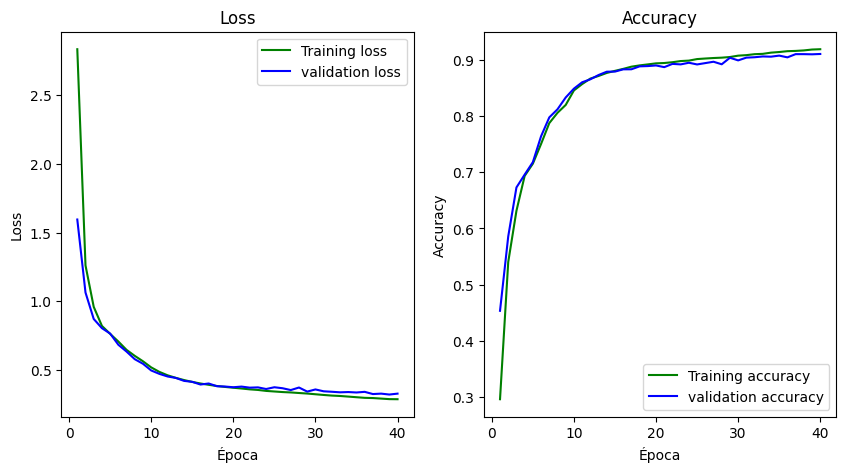

In [77]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
acc_train = history.history['acc']
acc_val = history.history['val_acc']

epochs = range(1,n_epocas+1)

fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].plot(epochs, loss_train, 'g', label='Training loss')
axs[0].plot(epochs, loss_val, 'b', label='validation loss')
axs[0].title.set_text('Loss')
axs[0].set(xlabel="Época", ylabel="Loss")
axs[0].legend()
axs[1].plot(epochs, acc_train, 'g', label='Training accuracy')
axs[1].plot(epochs, acc_val, 'b', label='validation accuracy')
axs[1].title.set_text('Accuracy')
axs[1].set(xlabel="Época", ylabel="Accuracy")
axs[1].legend()

fig.show()

In [78]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

predictions_matrix = model.predict(X_test)
predictions = np.argmax(predictions_matrix, axis=1)

print(f"Test Accuracy: {accuracy_score(y_pred=predictions,y_true=y_test_original)}")
print(f"Test Recall: {recall_score(y_pred=predictions,y_true=y_test_original,average='macro')}")
print(f"Test Precision: {precision_score(y_pred=predictions,y_true=y_test_original,average='macro')}")

313/313 [==============================] - 0s 1ms/step
Test Accuracy: 0.91
Test Recall: 0.9079710134631064
Test Precision: 0.9084547459997928
